In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd

In [2]:
table = pd.read_csv("./csv_dataset/handshake_right_2.csv")

In [3]:
dictable = table.to_dict()

In [4]:
def plot_arr(chart, part_arr):
    part_x = [x[0] for x in part_arr]
    part_y = [y[1] for y in part_arr]
    part_z = [z[2] for z in part_arr]
    chart.plot(xs=part_x, ys=part_y, zs=part_z)
    
def str_to_array(string):
    import ast
    itm = dictable[string]
    all_pos = [None] * len(itm)
    for k, v in itm.items():
        all_pos[k] = ast.literal_eval(v)
    return all_pos

In [5]:
glava_arr = str_to_array("Head")

lr_arr = str_to_array("LeftHand")
    
dr_arr = str_to_array("RightHand")

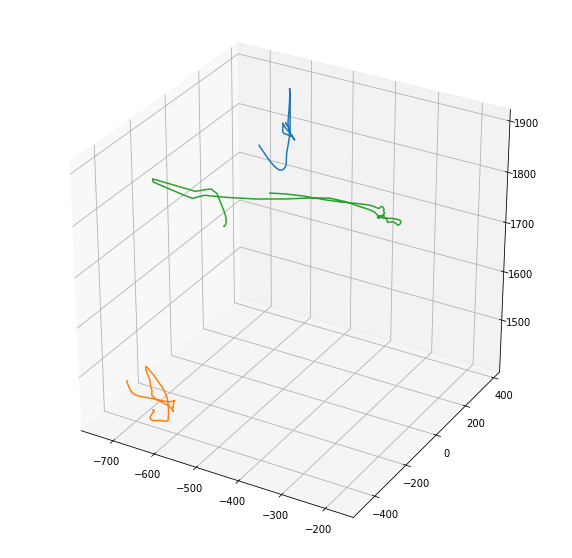

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection='3d')
plot_arr(ax1, glava_arr)
plot_arr(ax1, lr_arr)
plot_arr(ax1, dr_arr)

for some reason glava & left hand have same coordinates